<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/bayesian-model-averaging-method/BMA_basedon_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from functools import partial
import tqdm
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
import sklearn
import sklearn.preprocessing

In [53]:
!pip install blitz-bayesian-pytorch
import blitz
import blitz.modules
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
def generating_sample(func, var_inforamtion, num_train, num_test):

  num = num_train + num_test
  num = int(num)
  # sampling for inputs
  ins = np.zeros(shape = [num, 1])
  var_num = len(var_inforamtion)
  for i in range(var_num):
    distribution_infromation = var_inforamtion[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
  ins = np.delete(ins, 0, axis = 1)
  # calculating for response
  labs = func(ins)
  
  ins = sklearn.preprocessing.StandardScaler().fit_transform(ins)
  labs = sklearn.preprocessing.StandardScaler().fit_transform(labs.reshape(-1,1))
  # transformation from numpy.array to torch.tensor
  
  ins = torch.from_numpy(ins).float()
  labs = torch.from_numpy(labs).float()
  
  # split to train_set and test_set
  train_volume = int(num_train)
  data_index = list(range(num))
  
  train_index = random.sample(range(0, num), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_ins, train_labs = ins[train_index, :], labs[train_index, :]
  test_ins, test_labs = ins[test_index, :], labs[test_index, :]

  # packaging by DataLoader and TensorDataset
  train_set = TensorDataset(train_ins, train_labs)
  train_set = DataLoader(train_set, batch_size = train_volume)
  
  test_set = TensorDataset(test_ins, test_labs)
  test_set = DataLoader(test_set, batch_size = train_volume)

  return train_set, test_set

In [55]:
@variational_estimator
class BayesianLinearRegression(nn.Module):

  def __init__(self, in_features, out_features):
    super().__init__()

    self.fc_1 = nn.Linear(in_features, in_features * 50)
    self.fc_2 = nn.Linear(in_features * 50, in_features * 100)
    self.fc_3 = nn.Linear(in_features * 100, in_features * 50)
    self.fc_4 = BayesianLinear(in_features * 50, in_features * 20)
    self.fc_5 = BayesianLinear(in_features * 20, out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = self.relu(self.fc_4(x))
    y = self.fc_5(x)
    
    return y

In [56]:
def evaluate(model, test_set, num_samples, std_multiplier, iterior):

  for index, (x_test, y_test) in enumerate(test_set):
    
    preds = [model(x_test) for i in range(num_samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    
    ic_acc = (ci_lower <= y_test) * (ci_upper >= y_test)
    ic_acc = ic_acc.float().mean()

    plt.figure(iterior, figsize=(10, 8), dpi=80)
    count = list(range(means.shape[0]))
    plt.scatter(count, y_test, color = 'black')
    plt.plot(count, means.detach().numpy(), color = 'blue')
    
    plt.fill_between(count, ci_lower.squeeze().detach().numpy(), ci_upper.squeeze().detach().numpy(), alpha = 0.4, color = 'blue')
    
    plt.title(f'the error bar of the mdoel trained {iterior}th in test set ')
    plt.xlabel('Index of test data')
    plt.ylabel('Response')
    plt.show()
    print(f"the accuracy in test set is {ic_acc}")
  
  return means, stds

In [57]:
def training_precess(model, train_set, test_set, train_epoch):

  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  #criterion = torch.nn.SmoothL1Loss()
  criterion = torch.nn.MSELoss()
  loss_hist = []
  for epoch in trange(train_epoch):
    for index, (x_train, y_train) in enumerate(train_set):
      optimizer.zero_grad()
      loss = model.sample_elbo(inputs = x_train, labels = y_train, criterion = criterion, sample_nbr = 3, complexity_cost_weight = 1 / x_train.shape[0])
      loss_hist.append(loss.item())
      
      loss.backward()
      optimizer.step()
    
    if epoch % 500 == 0:
      evaluate(model, test_set, num_samples = 200, std_multiplier = 2, iterior = epoch)
  
  evaluate(model, test_set, num_samples = 100, std_multiplier = 2, iterior = epoch)
  plt.figure(epoch + 1, figsize=(10, 8), dpi=80)
  plt.plot(loss_hist)
  
  return model

In [58]:
def posterior_evaluation(func, model, var_information, num_samples):
  # sampling
  num = int(num_samples)
  ins = np.zeros(shape = [num, 1])
  var_num = len(var_information)
  for i in range(var_num):
    distribution_infromation = var_information[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
  ins = np.delete(ins, 0, axis = 1)

  labs = func(ins)

  ins = sklearn.preprocessing.StandardScaler().fit_transform(ins)
  labs = sklearn.preprocessing.StandardScaler().fit_transform(labs.reshape(-1,1))

  preds = [model(torch.from_numpy(ins).float()) for i in range(200)]
  preds = torch.stack(preds, dim = 0)
  plt.figure(9999999,figsize=(10, 8), dpi=80)
  sns.distplot(labs, hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  sns.distplot(preds.detach().numpy(), hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  plt.title('posterior distribution of bnn VS true distribution from the true func')

In [59]:
from bma_demo import Mathematical_examples_1
inf_model1 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'var_2': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_model2 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'var_2': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_model3 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'var_2': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'var_3': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_model4 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'var_2': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'var_3': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
batch_size = 200
trainset_model1, testset_model1 = generating_sample(Mathematical_examples_1.func_1, inf_model1, batch_size, 50)
trainset_model2, testset_model2 = generating_sample(Mathematical_examples_1.func_2, inf_model2, batch_size, 50)
trainset_model3, testset_model3 = generating_sample(Mathematical_examples_1.func_3, inf_model3, batch_size, 50)
trainset_model4, testset_model4 = generating_sample(Mathematical_examples_1.func_4, inf_model4, batch_size, 50)
for i, (x, y) in enumerate(trainset_model1):
  print(f'ins shape of train data{x.shape}')
  print(f'labs shape of train data{y.shape}')

ins shape of train datatorch.Size([200, 3])
labs shape of train datatorch.Size([200, 1])


  0%|          | 0/2500 [00:00<?, ?it/s]

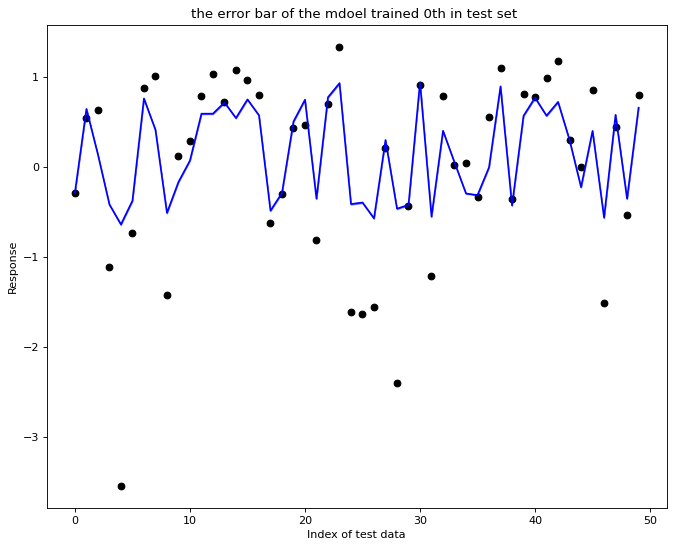

the accuracy in test set is 0.05999999865889549


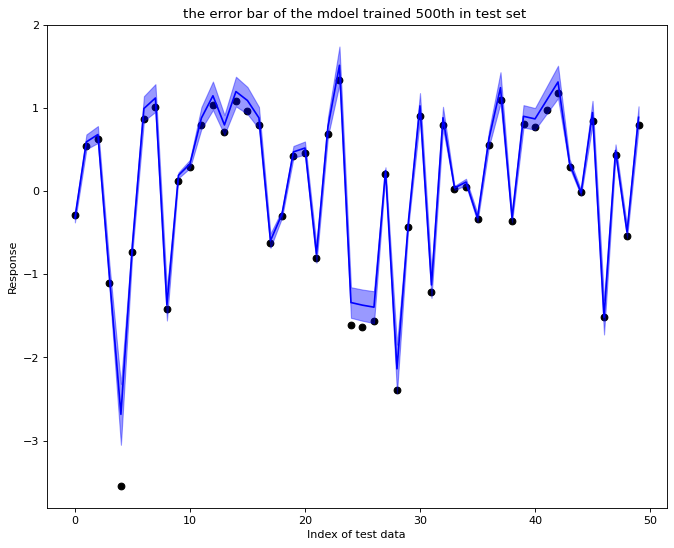

the accuracy in test set is 0.8600000143051147


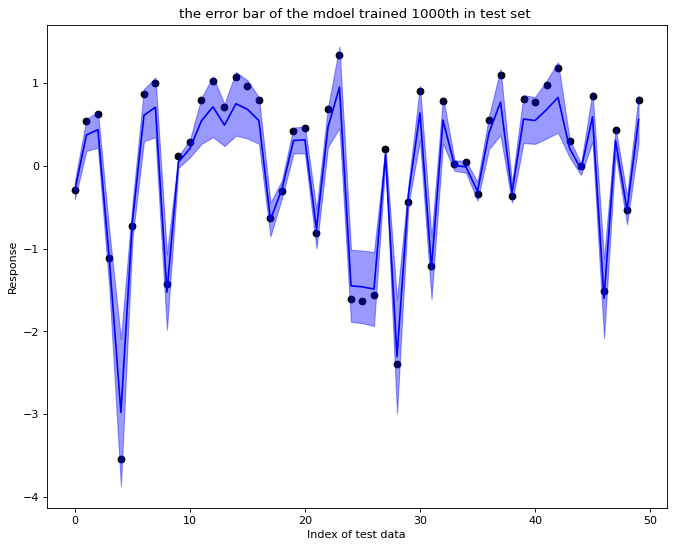

the accuracy in test set is 0.9800000190734863


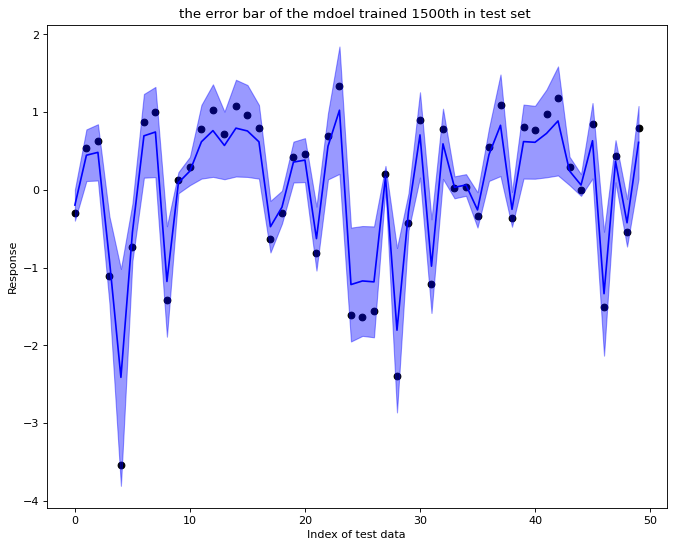

the accuracy in test set is 1.0


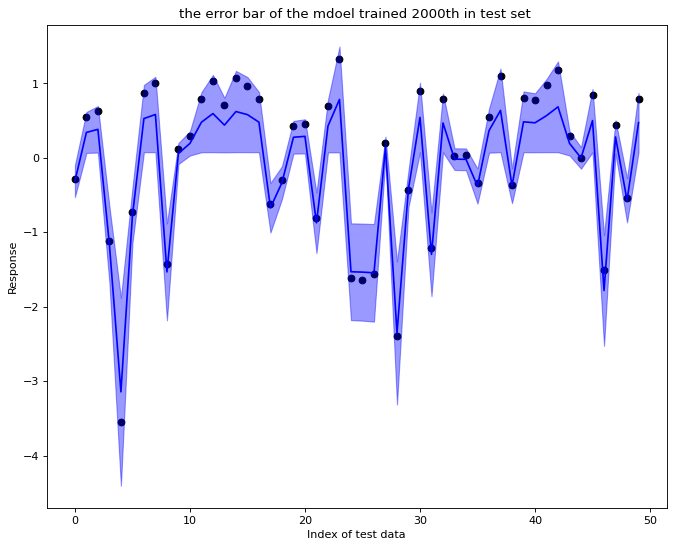

the accuracy in test set is 1.0


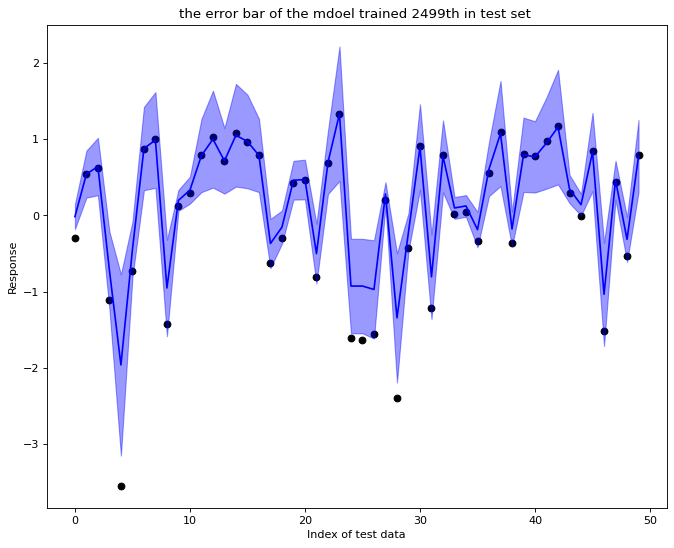

the accuracy in test set is 0.8799999952316284


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


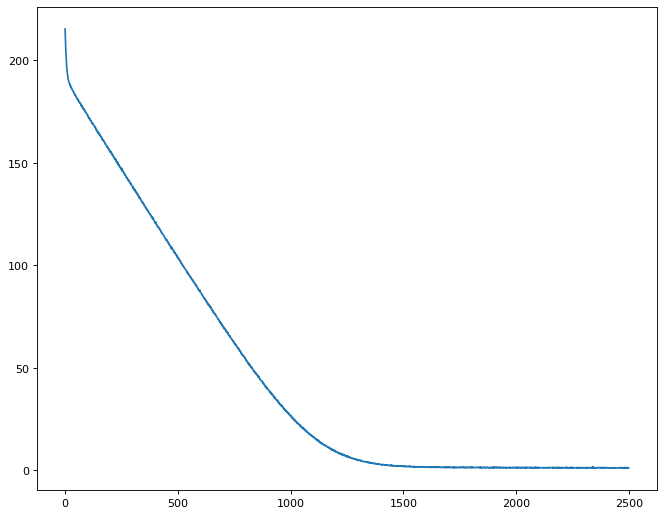

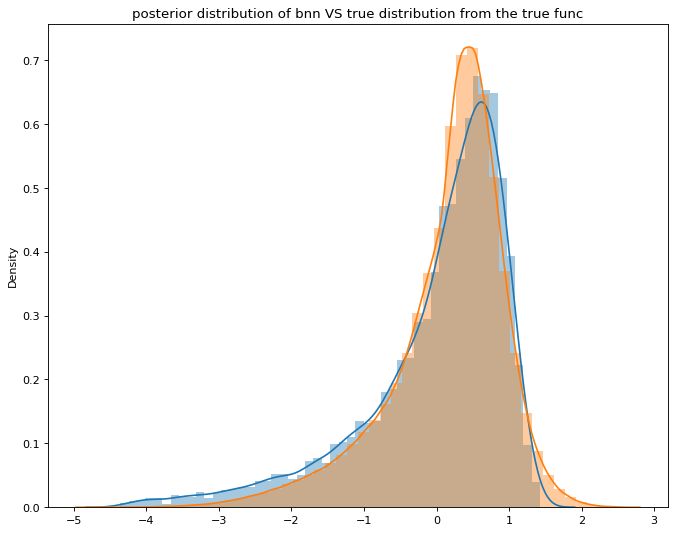

In [60]:
func1 = BayesianLinearRegression(3, 1)
training_precess(func1, trainset_model1, testset_model1, 2500)
posterior_evaluation(Mathematical_examples_1.func_1, func1, inf_model1, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

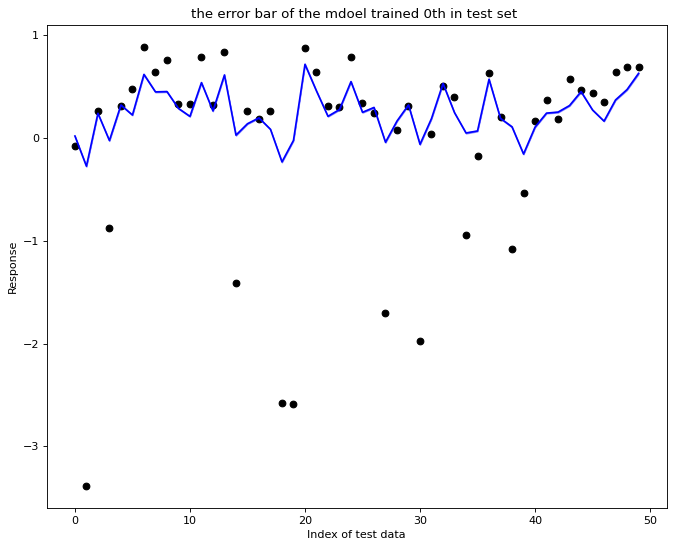

the accuracy in test set is 0.0


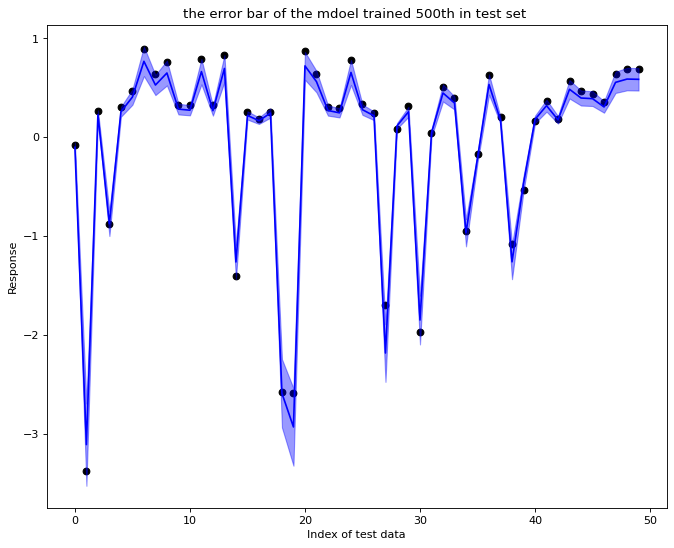

the accuracy in test set is 0.7400000095367432


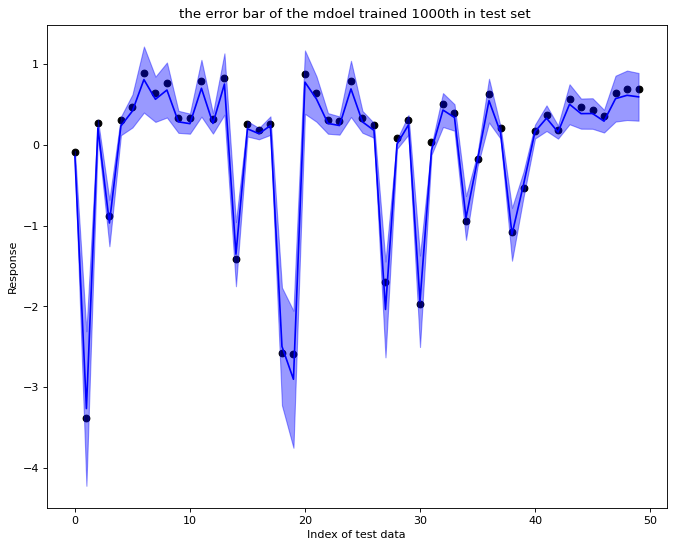

the accuracy in test set is 0.9599999785423279


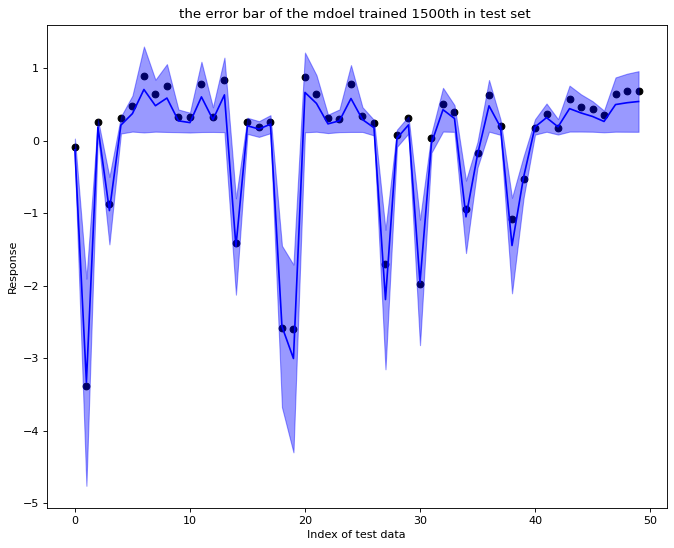

the accuracy in test set is 1.0


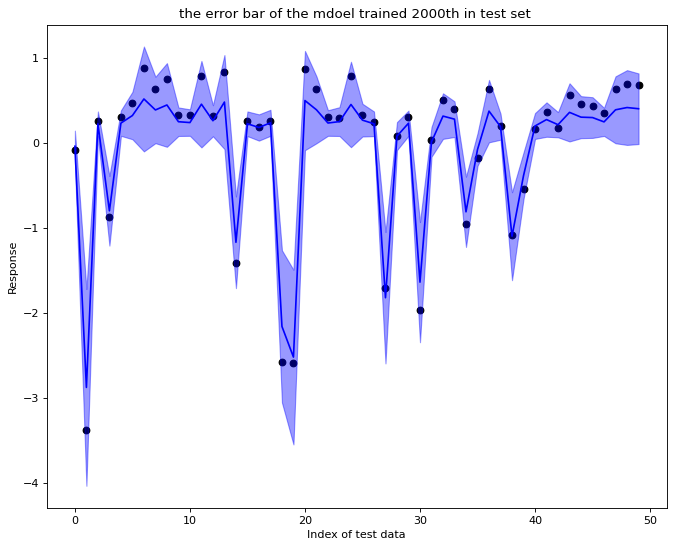

the accuracy in test set is 1.0


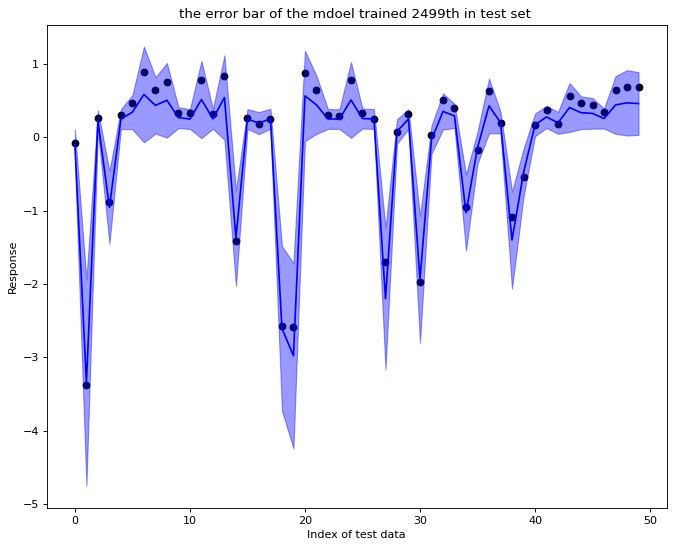

the accuracy in test set is 1.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


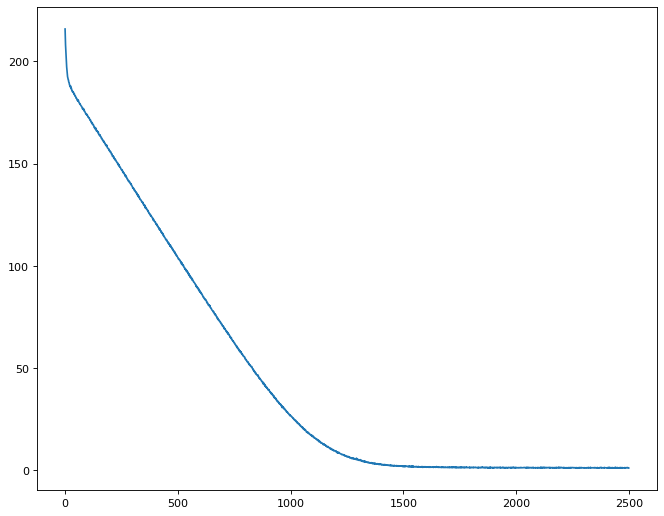

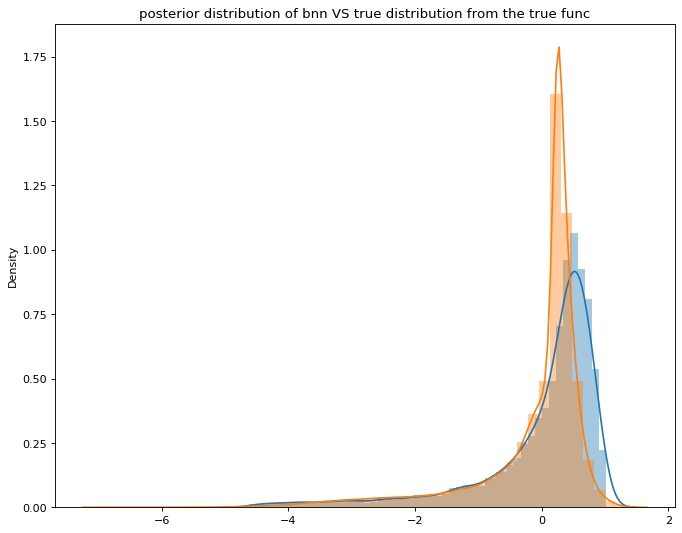

In [61]:
func2 = BayesianLinearRegression(3, 1)
training_precess(func2, trainset_model2, testset_model2, 2500)
posterior_evaluation(Mathematical_examples_1.func_2, func2, inf_model2, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

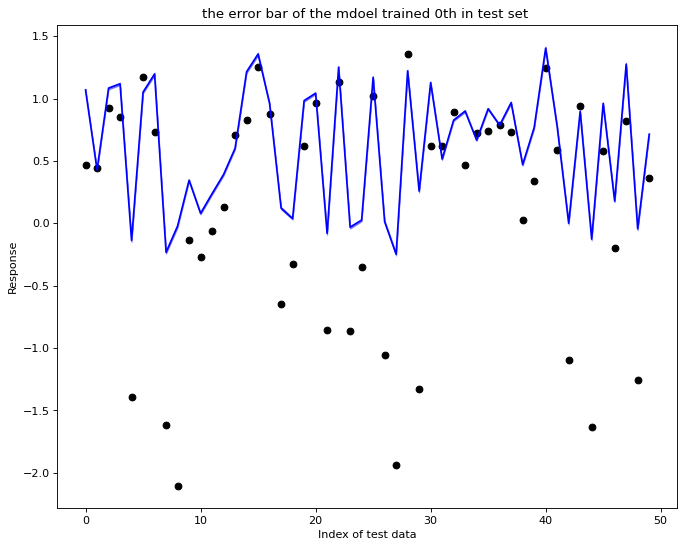

the accuracy in test set is 0.019999999552965164


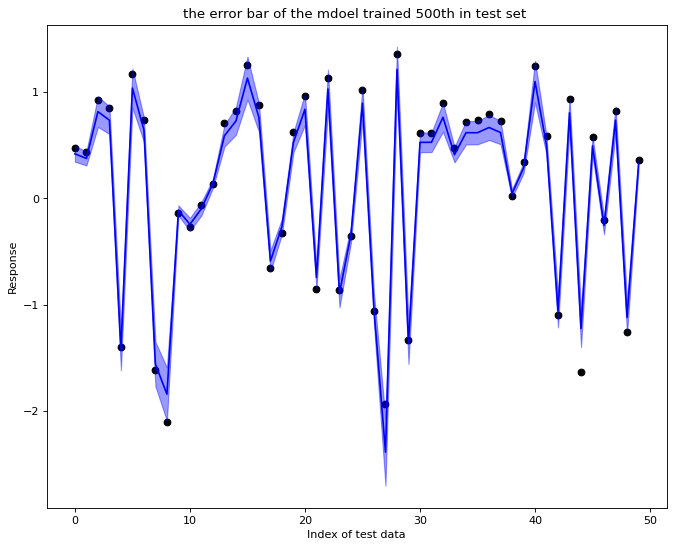

the accuracy in test set is 0.8199999928474426


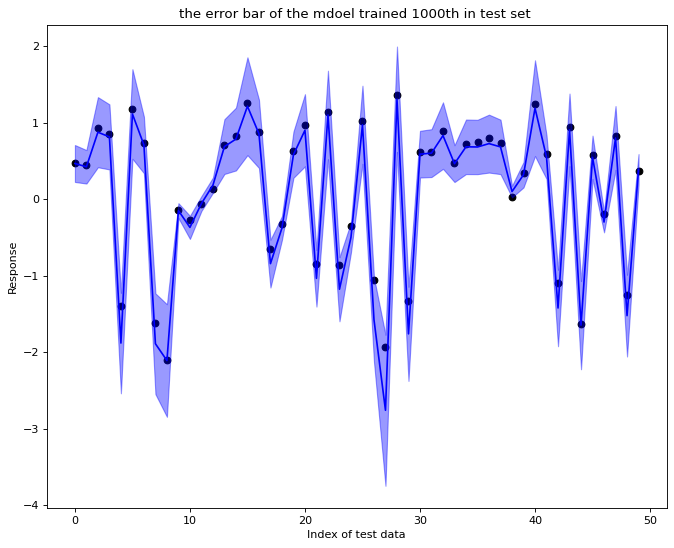

the accuracy in test set is 1.0


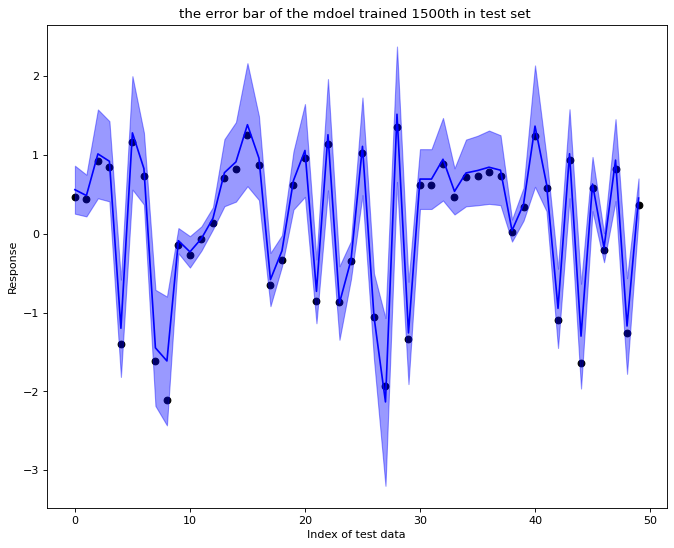

the accuracy in test set is 1.0


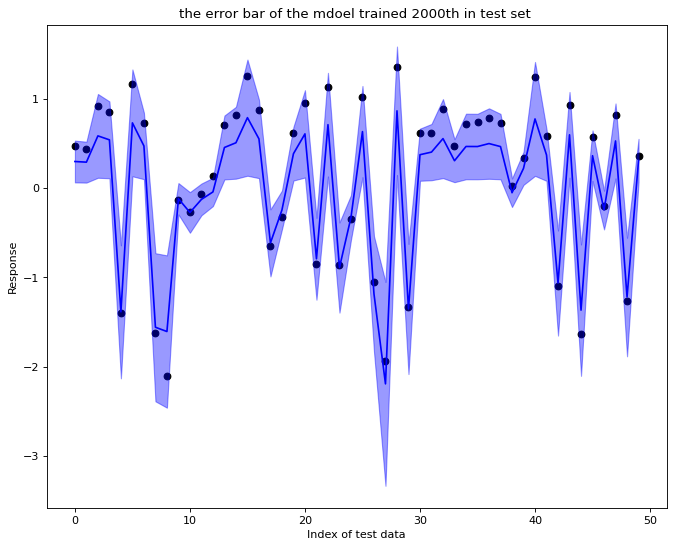

the accuracy in test set is 0.9800000190734863


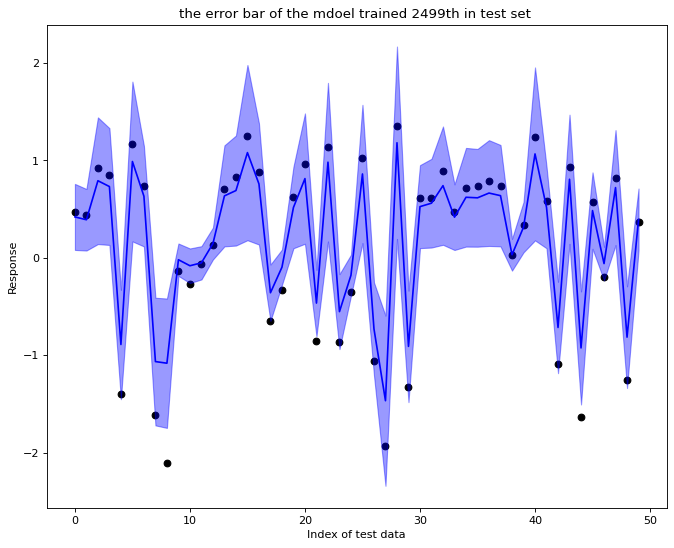

the accuracy in test set is 0.8799999952316284


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


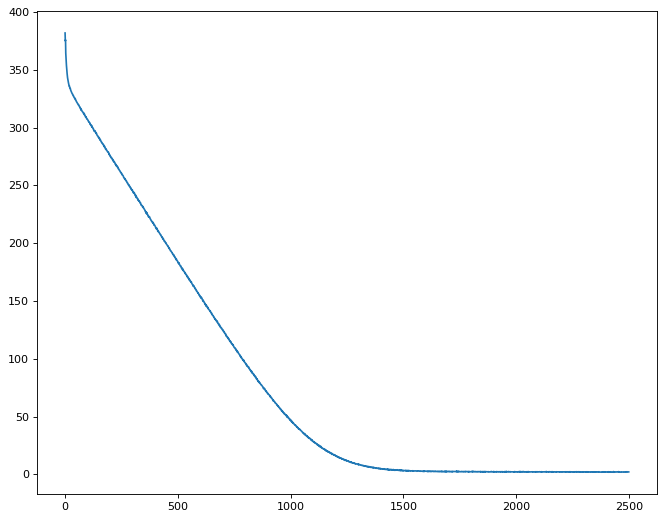

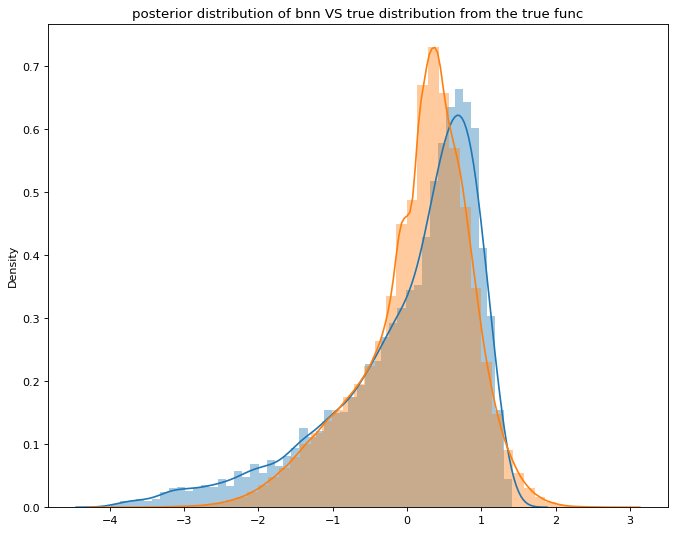

In [62]:
func3 = BayesianLinearRegression(4, 1)
training_precess(func3, trainset_model3, testset_model3, 2500)
posterior_evaluation(Mathematical_examples_1.func_3, func3, inf_model3, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

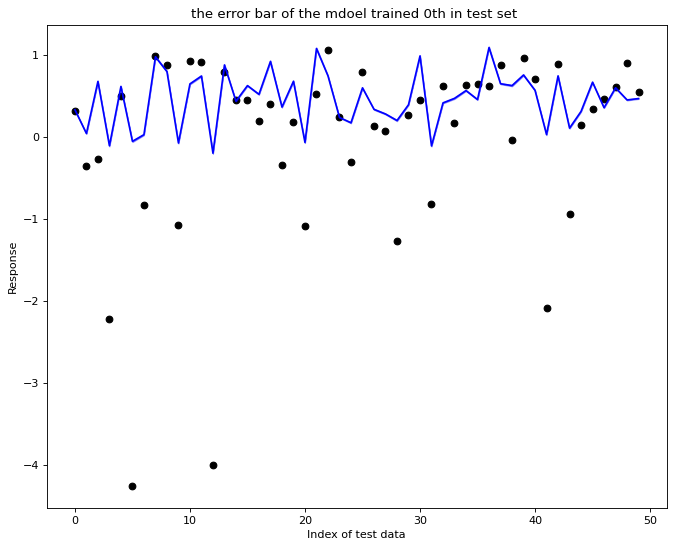

the accuracy in test set is 0.03999999910593033


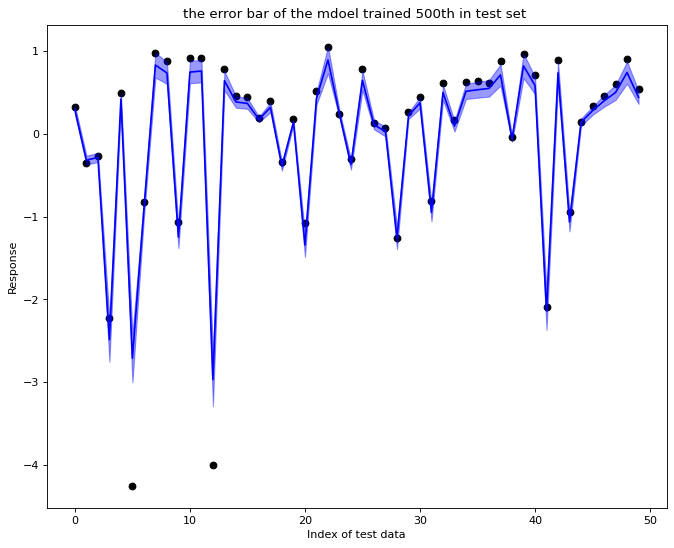

the accuracy in test set is 0.41999998688697815


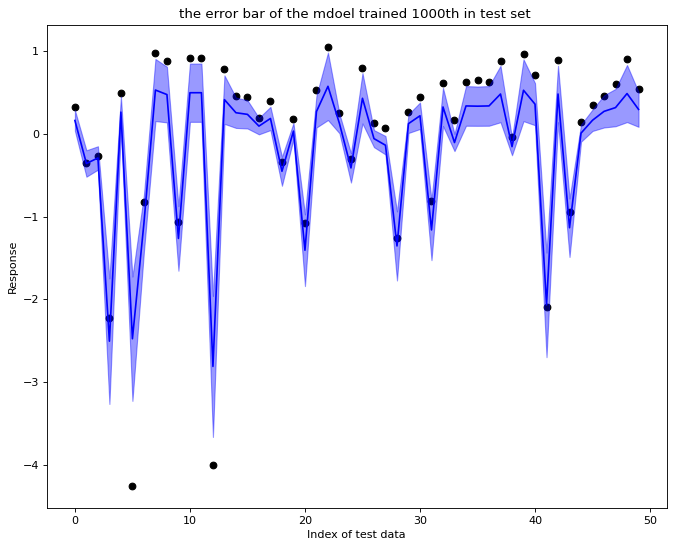

the accuracy in test set is 0.2800000011920929


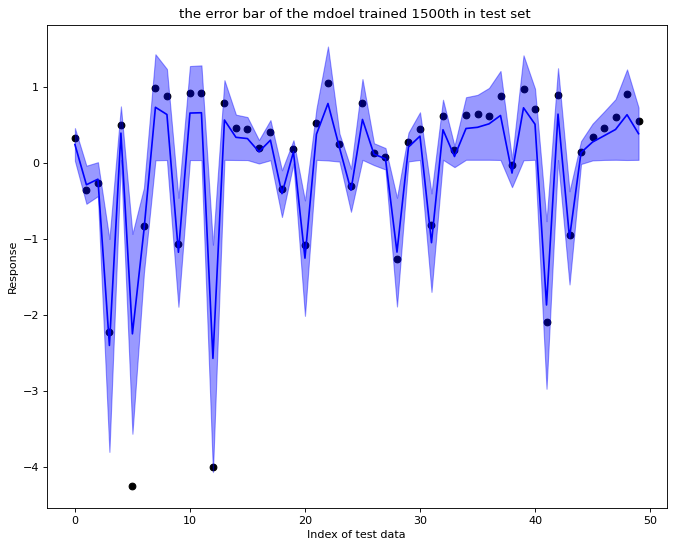

the accuracy in test set is 0.9800000190734863


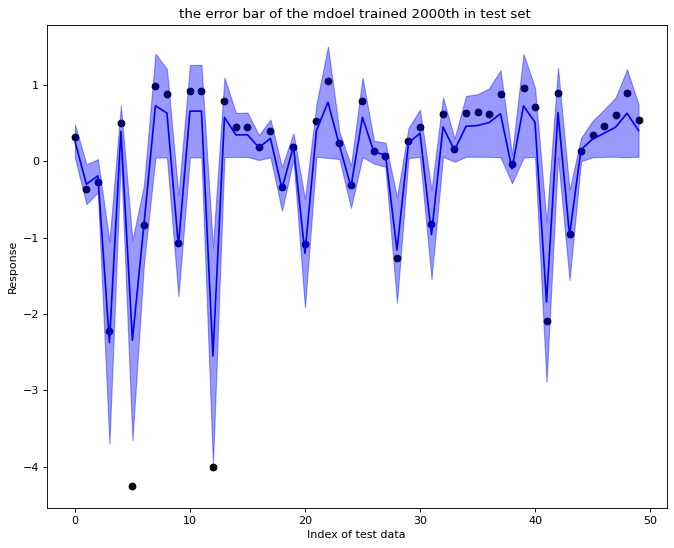

the accuracy in test set is 0.9599999785423279


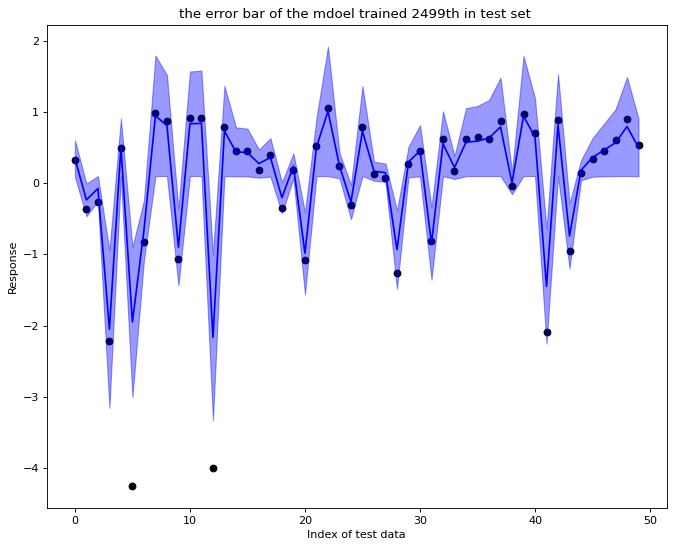

the accuracy in test set is 0.9399999976158142


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


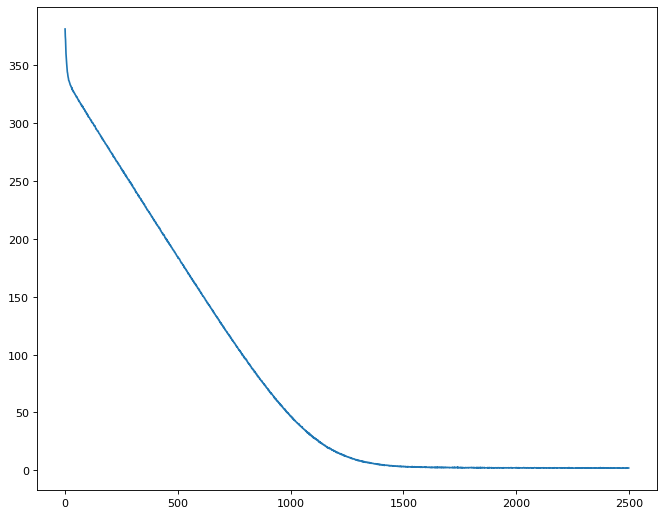

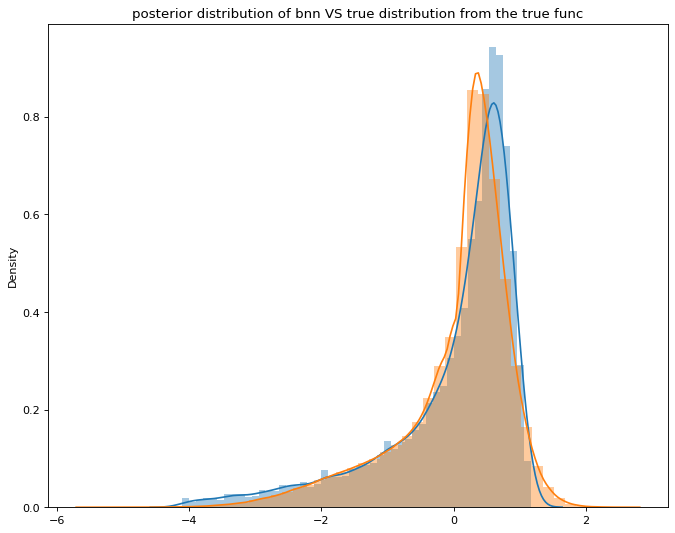

In [63]:
func4 = BayesianLinearRegression(4, 1)
training_precess(func4, trainset_model4, testset_model4, 2500)
posterior_evaluation(Mathematical_examples_1.func_4, func4, inf_model4, 10000)

In [64]:
class likelihood_calculation(object):
  
  def __init__(self, input_exp, output_exp, theta_information, bnn_model, count_theta, count_weight):
    self.input_exp = input_exp
    self.output_exp = output_exp
    self.theta_information = theta_information
    self.data_volume = input_exp.shape[0]
    self.count_weight = count_weight
    self.count_theta = count_theta
    self.model = bnn_model
  
  def sampling_theta(self):
    
    theta_num = len(self.theta_information)
    thetas = np.zeros(shape = [self.count_theta, self.data_volume, theta_num])
    theta = np.zeros(shape = [1, theta_num])
    for j in range(self.count_theta):
      for i in range(theta_num):
        distribution_infromation = self.theta_information[f'theta_{i}']
        distribution_name = distribution_infromation[0]
        disrtibution_loc = distribution_infromation[1]
        disrtibution_scale = distribution_infromation[2]
        theta[0, i] = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [1])
      thetas[j, :, :] = np.repeat(theta, self.data_volume, axis = 0)
    return thetas
  
  def predictive(self, inputs):
    
    inputs = inputs.float()
    preds = [self.model(inputs) for i in range(self.count_weight)]
    preds = torch.stack(preds).squeeze()

    return preds.detach().numpy()


  def sigma2_mle(self, out_model):
    
    out_exp = np.repeat(self.output_exp,self.count_weight, axis = 1)
    error = np.mean(np.power(out_exp - out_model, 2), axis = 0)
    
    return np.mean(np.power(out_exp - out_model, 2), axis = 0)
  
  def conditional_marginal_likelihood(self, sigma2):

    return np.power((2 * np.pi * sigma2), -(self.data_volume / 2)) * np.exp(-(self.data_volume / 2))

  def marginal_likelihood(self, theta):

    ins = np.concatenate((self.input_exp, theta), axis = 1)

    out_model = self.predictive(torch.from_numpy(ins).float())
    
    sigma = self.sigma2_mle(out_model.T).reshape(-1,1)
    
    store_cl = self.conditional_marginal_likelihood(sigma)
    
    return np.mean(store_cl, axis = 0)
  
  def likelihood(self):
    thetas = self.sampling_theta()
    store_l = np.zeros(shape=[self.count_theta, 1])
    for i in trange(self.count_theta):
      
      store_l[i, 0] = self.marginal_likelihood(thetas[i, :, :])
      plt.plot(store_l[i, 0])
    
    return np.sum(store_l, axis = 0) / (self.count_theta)